# AquaPredict

## Dataset Information

### Location:
An Internet of Things Labelled Dataset for Aquaponics Fish Pond Water Quality Monitoring System,
HiPIC Research Group, Department of Computer Science, University of Nigeria Nsukka, Nigeria
Click here for more details

### Contact:
Collins Udanor, email: collins.udanor@unn.edu.ng
Blessing Oguokiri, email: blessing.ogbuokiri@unn.edu.ng

### Dataset Information:
Aquaponics meta-data
The enclosed datasets are generated from freshwater aquaponics catfish ponds. The datasets are generated automatically at 5 seconds intervals using the following water quality sensors driven by the ESP 32 microcontroller: Dallas Instrument Temperature sensor (DS18B20), DF Robot Turbidity sensor, DF Robot Dissolved Oxygen sensor, DF Robot pH sensor V2.2, MQ-137 Ammonia sensor, and MQ-135 Nitrate sensor.
The project is funded by the Lacuna Award for Agriculture in Sub-Saharan Africa 2020 under the management of the Meridian Institute Colorado, USA.
The datasets and results in this section were sensor readings from June to mid-October 2021. There are 12 datasets, each from 12 aquaponics catfish ponds. Each of the 12 ponds IoT unit has six sensors (temperature, turbidity, dissolved oxygen, pH, ammonia, nitrate). As of the time of this report each unit has generated over 170,000 instances. The datasets are downloaded at intervals, cleaned, and labelled.

#### The attributes are:
1) Date/Time
2) Temperature
3) Turbidity
4) Dissolved Oxygen (DO)
5) pH
6) Ammonia
7) Nitrate
8) Population of fish in the pond
9)Length of Fish
10) Weight of Fish

### Attribute Information:
All attributes are continuous

No statistics available, but suggest to standardise variables for certain uses (e.g. for use with classifiers that are NOT scale-invariant)

*NOTE:* Attributes 9 and 10 are class identifiers that can be used differently. For example, one may need to predict the length of the fish using the water quality parameters (2-7) or in addition to the population or stocking density (parameter 8). Similarly, the same can be done using the weight attribute.

Source: [https://www.kaggle.com/datasets/ogbuokiriblessing/sensor-based-aquaponics-fish-pond-datasets](https://www.kaggle.com/datasets/ogbuokiriblessing/sensor-based-aquaponics-fish-pond-datasets)

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import pd, plt, np
from dateutil import parser


In [3]:
plt.rcParams['figure.figsize'] = (20, 5)

## Constants

In [4]:
OPTIMAL_WATER_TEMP = 28
OPTIMAL_BED_TEMP = 17

## Data

### Reading and cleaning the dataset

Take data from the first pond from [kaggle dataset](https://www.kaggle.com/datasets/ogbuokiriblessing/sensor-based-aquaponics-fish-pond-datasets).

In [7]:
df = pd.read_csv(r"C:\Users\Aniek\Documents\GitHub\AquaPredict\backend\ml\data\IoTpond1.csv", parse_dates=['created_at'], date_parser=lambda col: parser.parse(col, tzinfos={"CET": "UTC+1"}))
df.head()

,created_at,entry_id,Temperature (C),Turbidity(NTU),Dissolved Oxygen(g/ml),PH,Ammonia(g/ml),Nitrate(g/ml),Population,Fish_Length(cm),Fish_Weight(g)
0,2021-06-19 00:00:05+01:00,1889,24.8750,100,4.505,8.43365,0.45842,193,50,7.11,2.91
1,2021-06-19 00:01:02+01:00,1890,24.9375,100,6.601,8.43818,0.45842,194,50,7.11,2.91
2,2021-06-19 00:01:22+01:00,1891,24.8750,100,15.797,8.42457,0.45842,192,50,7.11,2.91
3,2021-06-19 00:01:44+01:00,1892,24.9375,100,5.046,8.43365,0.45842,193,50,7.11,2.91
4,2021-06-19 00:02:07+01:00,1893,24.9375,100,38.407,8.40641,0.45842,192,50,7.11,2.91


Features which are not relevant to the temperature are removed.

In [8]:
df.drop(['entry_id', 'Turbidity(NTU)', 'Turbidity (NTU)', 'Dissolved Oxygen(g/ml)', 'PH', 'Ammonia(g/ml)', 'Nitrate(g/ml)','Population', 'Fish_Length(cm)', 'Fish_Length (cm)', 'Fish_Weight(g)', 'Fish_Weight (g)'], axis=1, inplace=True, errors='ignore')
# rename columns Temperature (C) to temp_water
df.rename(columns={'Temperature (C)': 'temp_water', 'Temperature(C)': 'temp_water'}, inplace=True)
# create DatetimeIndex from created_at
df.index = df.created_at

In [9]:
df.describe(datetime_is_numeric=True)

,temp_water
count,83126.000000
mean,24.573376
std,0.861532
min,-127.000000
25%,24.125000
50%,24.562500
75%,24.937500
max,27.750000


Remove rows with temperature value -127.

In [10]:
# remove rows with temp_water == -127
df = df[df.temp_water != -127]

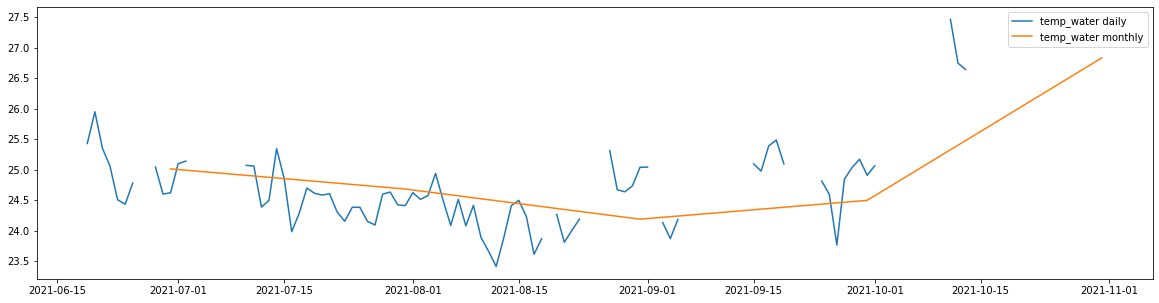

In [11]:
# show plot of temp_water. Agreggate by day. Plot as line chart
plt.plot(df.temp_water.resample('D').mean(), label='temp_water daily')
plt.plot(df.temp_water.resample('M').mean(), label='temp_water monthly')
plt.legend()
plt.show()

### Adding ambient and growbed temperatures

Assuming that a soil temperature changes more dynamically than the water temperature and air temperature changes more dynamically than the soil temperature we will introduce 2 new parameters.
Those parameters are created by multiplying the difference between a simple moving average of water temperature and the current water temperature at a given point. Then, the functions are shifted in time to simulate the behaviour of substances with different heat capacities.

1. Calculate a simple moving average of water temperature.

In [12]:
# add simple moving average of temp_water from 3 days to df
df['temp_water_sma'] = df["temp_water"].rolling('3D').mean()

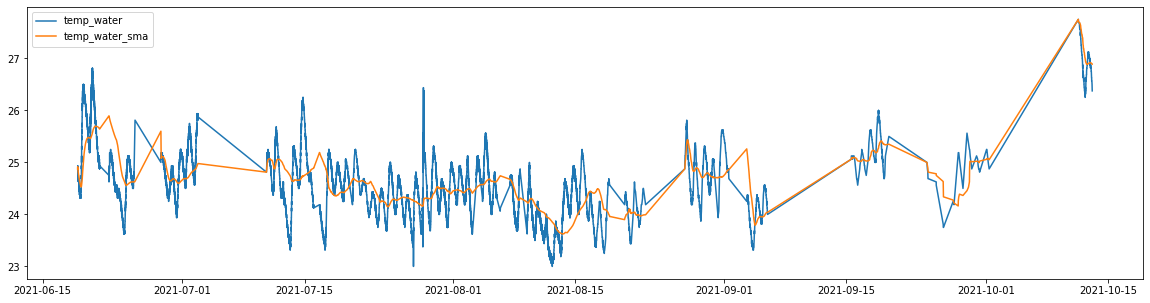

In [13]:
# plot temp_water and temp_water_sma
plt.plot(df.temp_water, label='temp_water')
plt.plot(df.temp_water_sma, label='temp_water_sma')
plt.legend()
# increase width of the graph
plt.show()

2. Create new columns by amplifying the distance from `sma`. Ambient temperature in the investigated place and period should range from 21 to 29 [(1)](https://www.climatestotravel.com/climate/nigeria). 

In [14]:
# Amplify distance between `sma` and `temp_water`
df['temp_bed'] = df['temp_water_sma'] + (df['temp_water'] - df['temp_water_sma']) * 2
df['temp_ambient'] = df['temp_water_sma'] + (df['temp_water'] - df['temp_water_sma']) * 3

In [15]:
df.describe()

,temp_water,temp_water_sma,temp_bed,temp_ambient
count,83125.000000,83125.000000,83125.000000,83125.000000
mean,24.575199,24.567865,24.582533,24.589867
std,0.682535,0.496365,1.105889,1.586754
min,23.000000,23.624510,21.694683,20.076866
25%,24.125000,24.285687,23.767584,23.431991
50%,24.562500,24.567669,24.529879,24.505025
75%,24.937500,24.777902,25.249326,25.616525
max,27.750000,27.750000,28.654201,30.870902


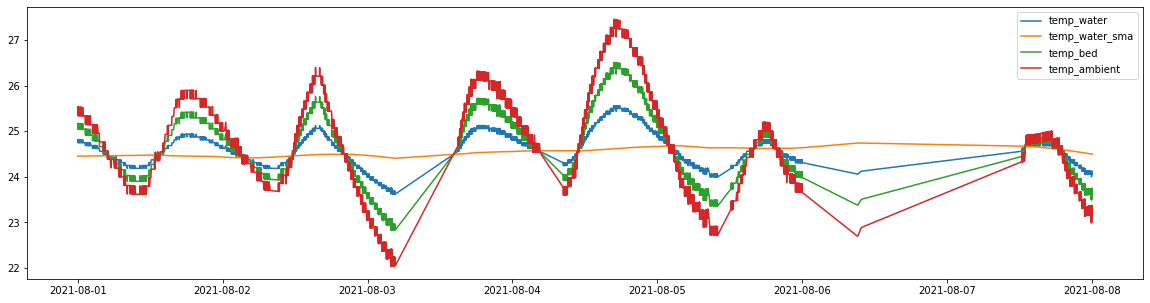

In [16]:
# get slice of df from 2021-08-01 to 2021-08-07
df_slice = df.loc['2021-08-01':'2021-08-07']
# plot temp_water and temp_water_sma and temp_bed and temp_ambient
plt.plot(df_slice.temp_water, label='temp_water')
plt.plot(df_slice.temp_water_sma, label='temp_water_sma')
plt.plot(df_slice.temp_bed, label='temp_bed')
plt.plot(df_slice.temp_ambient, label='temp_ambient')
plt.legend()

plt.show()

3. Add time offset to water and soil temperatures.

In [17]:
# shift by periods
df_shift_simple = df 
df_shift_simple["temp_bed"] = df["temp_bed"].shift(periods=200)
df_shift_simple["temp_water"] = df["temp_water"].shift(periods=400)

df_shifted = df_shift_simple

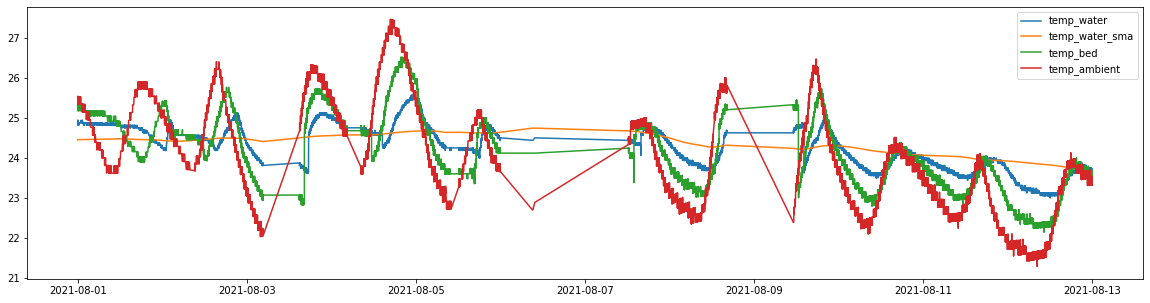

In [18]:
# get slice of df from 2021-08-01 to 2021-08-07
df_slice = df_shifted.loc['2021-08-01':'2021-08-12']
# plot temp_water and temp_water_sma and temp_bed and temp_ambient
plt.plot(df_slice.temp_water, label='temp_water' )
plt.plot(df_slice.temp_water_sma, label='temp_water_sma')
plt.plot(df_slice.temp_bed, label='temp_bed')
plt.plot(df_slice.temp_ambient, label='temp_ambient')

plt.legend()

In [19]:
df = df_shifted

### Adding heater status

Column representing the heater status is added based on optimal temperature for tilapia.

In [20]:
# add column "water_heater" with 1 if temp_water < OPTIMAL_WATER_TEMP and 0 otherwise
df['water_heater'] = np.where(df['temp_water'] < OPTIMAL_WATER_TEMP, 1, 0).astype('int8')

   water_heater
1         82725
0           400


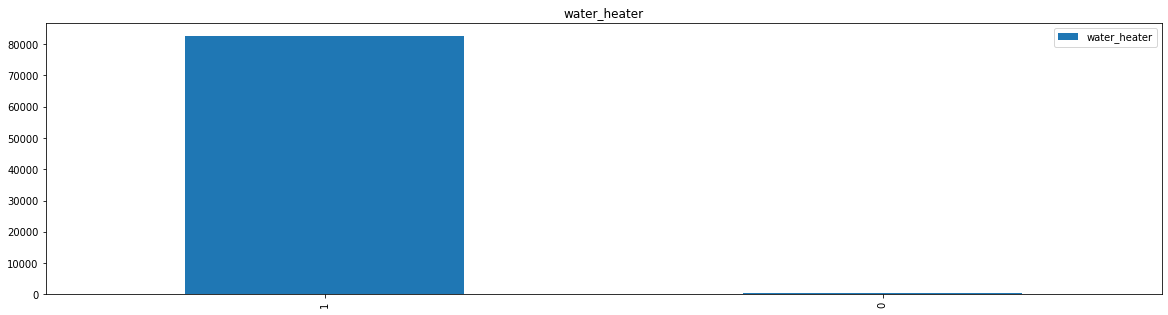

In [21]:
counts = pd.DataFrame(df["water_heater"].value_counts())
counts.plot(kind='bar', title='water_heater')
print(counts)

Save dataset modified dataset to the file.

In [23]:
# remove index from df
import os
os.makedirs('tmp', exist_ok=True)
df.reset_index(drop=True, inplace=True)

df.to_csv('tmp/aquaponics.csv')
df.to_feather('tmp/aquaponics.feather')


In [24]:
col = ['temp_water', 'temp_water_sma', 'temp_bed', 'temp_ambient']

for column in col:
    df[column].fillna(value=df[column].mean(), inplace=True)
df

,created_at,temp_water,temp_water_sma,temp_bed,temp_ambient,water_heater
0,2021-06-19 00:00:05+01:00,24.567736,24.875000,24.577761,24.875000,0
1,2021-06-19 00:01:02+01:00,24.567736,24.906250,24.577761,25.000000,0
2,2021-06-19 00:01:22+01:00,24.567736,24.895833,24.577761,24.833333,0
3,2021-06-19 00:01:44+01:00,24.567736,24.906250,24.577761,25.000000,0
4,2021-06-19 00:02:07+01:00,24.567736,24.912500,24.577761,24.987500,0
...,...,...,...,...,...,...
83120,2021-10-13 02:48:31+01:00,24.875000,26.898214,27.681250,25.891071,1
83121,2021-10-13 03:17:36+01:00,24.937500,26.896623,27.681818,25.894254,1
83122,2021-10-13 03:46:49+01:00,25.187500,26.894752,27.682292,25.710495,1
83123,2021-10-13 04:13:23+01:00,25.187500,26.892312,27.682692,25.340376,1


In [25]:
# split into data and decision variables
y = df.iloc[:, -1:].values
x = df.iloc[:, 1:-1].values

In [26]:
#split into training and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 1/4, random_state = 0)

In [28]:
#scale data and feed into random forest
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

#random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 0)
rf.fit(x_train, y_train)
rfy_pred = rf.predict(x_test)


#linear regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = 0)
lr.fit(x_train, y_train)
lry_pred = lr.predict(x_test)

#SVC
from sklearn.svm import SVC
clf = SVC(kernel = 'linear')
clf.fit(x_train,y_train)

clf_pred = clf.predict(x_test)

C:\Users\Aniek\AppData\Local\Temp\ipykernel_11140\2100249755.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)
C:\Users\Aniek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aniek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
from sklearn.metrics import accuracy_score
print(f'Random Forest: {accuracy_score(y_test, rfy_pred)}')
print("\n")
print(f'Logistic Regression: {accuracy_score(y_test, lry_pred)}')
print("\n")
print(f'SVC: {accuracy_score(y_test, clf_pred)}')

Random Forest: 1.0


Logistic Regression: 0.9954287364065056


SVC: 0.9954287364065056


In [31]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(n_splits = 10, random_state=20, shuffle= True)
finalAccuracy = cross_val_score(rf, x, y, scoring = 'accuracy', cv=cv,n_jobs=-1)
print('Random Forest Accuracy: %.3f (%.3f)'% (mean(finalAccuracy),std(finalAccuracy)))
pred = rf.predict(x)
finalAccuracy = accuracy_score(y, pred)
df['predicted'] = pred
dfShape = df.shape
df

Random Forest Accuracy: 1.000 (0.000)


,created_at,temp_water,temp_water_sma,temp_bed,temp_ambient,water_heater,predicted
0,2021-06-19 00:00:05+01:00,24.567736,24.875000,24.577761,24.875000,0,1
1,2021-06-19 00:01:02+01:00,24.567736,24.906250,24.577761,25.000000,0,1
2,2021-06-19 00:01:22+01:00,24.567736,24.895833,24.577761,24.833333,0,1
3,2021-06-19 00:01:44+01:00,24.567736,24.906250,24.577761,25.000000,0,1
4,2021-06-19 00:02:07+01:00,24.567736,24.912500,24.577761,24.987500,0,1
...,...,...,...,...,...,...,...
83120,2021-10-13 02:48:31+01:00,24.875000,26.898214,27.681250,25.891071,1,1
83121,2021-10-13 03:17:36+01:00,24.937500,26.896623,27.681818,25.894254,1,1
83122,2021-10-13 03:46:49+01:00,25.187500,26.894752,27.682292,25.710495,1,1
83123,2021-10-13 04:13:23+01:00,25.187500,26.892312,27.682692,25.340376,1,1


##Testing

In [33]:
import pandas as pd
import importlib 

1. Create mock data dataset

In [85]:

def build_mockdata_aquaponics(values, device_id="60df87b4be3fc900069dac1f", start_time=1600000000000):
    id_array = [device_id] * len(values)
    
    temperature_array = [(24.875)] * len(values)
    turbidity_array = [(100)] * len(values)
    oxigen_array = [(6.601)] * len(values)
    ph_array = [(8.40641)] * len(values)
    ammonia_array = [(0.45802)] * len(values)
    nitrate_array = [(193)] * len(values)
    population_array = [(50)] * len(values)
    fishlength_array = [(7.11)] * len(values)
    fishweight_array = [(2.9)] * len(values)
    
    return pd.DataFrame({
        "created_at": pd.Series(id_array),
        "entry_id": pd.Series(id_array),
        "Temperature (C)": pd.Series(temperature_array, dtype="float64"),
        "Turbidity(NTU)": pd.Series(turbidity_array, dtype="int64"),
        "Dissolved Oxygen(g/ml)": pd.Series(oxigen_array, dtype="float64"),
        "PH": pd.Series(ph_array, dtype="float64"),        
        "Ammonia(g/ml)": pd.Series(ammonia_array, dtype="float64"),
        "Nitrate(g/ml)": pd.Series(nitrate_array, dtype="int64"),
        "Population": pd.Series(population_array, dtype="int64"),
        "Fish_Length(cm)": pd.Series(fishlength_array, dtype="float64"),
        "Fish_Weight(g)": pd.Series(fishweight_array, dtype="float64"),
    })

2. Use mock data to create first test that checks the length of the dataframe

In [87]:
df_mock = build_mockdata_aquaponics([100,70,40,20,10])
len(df_mock)
assert len( df_mock ) == 5

next test is to test if population column exists

In [95]:
df_mock = build_mockdata_aquaponics([100,70,50])
assert ('Population' in df_mock.columns), "The column Population does not exist in the dataframe"

next test is to test if population column has minus values

In [94]:
df_mock = build_mockdata_aquaponics([100,70,50])
assert sum(df_mock["Population"]<0) == 0, "There are some negative values in the Population column"

next test is to test if the datatype of the PH column is float64

In [97]:
df_mock = build_mockdata_aquaponics([100,70,50])
assert df_mock["PH"].dtype == "float64", "Datatype of the column PH is wrong"